In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

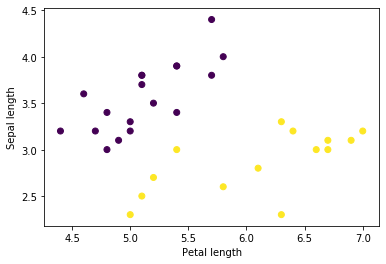

In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

if not os.path.exists(os.path.basename(train_dataset_url)):
    train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)
fname = os.path.basename(train_dataset_url)

dataset = tf.data.experimental.CsvDataset(fname, [tf.float32, tf.float32, tf.float32, tf.float32, tf.int32], 
                                         header=True)
# 暂时只保留而分类
def func(*items):
    return items[4] != 2
dataset = dataset.filter(func)
samples = next(iter(dataset.batch(32).take(1)))
plt.scatter(samples[0],
            samples[1],
            c=samples[4],
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [3]:
def pack_features_vector(*samples):
    features = tf.stack(list(samples[:4]), axis=1)
    labels =samples[4]
    return features, labels
dataset = dataset.batch(32).map(pack_features_vector)

In [4]:
features, labels = next(iter(dataset))
print(features)
print(labels)

tf.Tensor(
[[5.  2.3 3.3 1. ]
 [4.9 3.1 1.5 0.1]
 [5.7 3.8 1.7 0.3]
 [4.4 3.2 1.3 0.2]
 [5.4 3.4 1.5 0.4]
 [6.7 3.1 4.4 1.4]
 [5.1 3.7 1.5 0.4]
 [5.2 2.7 3.9 1.4]
 [6.9 3.1 4.9 1.5]
 [5.8 4.  1.2 0.2]
 [5.4 3.9 1.7 0.4]
 [6.3 3.3 4.7 1.6]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.2 3.5 1.5 0.2]
 [5.8 2.6 4.  1.2]
 [5.4 3.  4.5 1.5]
 [6.7 3.  5.  1.7]
 [6.3 2.3 4.4 1.3]
 [5.1 2.5 3.  1.1]
 [6.4 3.2 4.5 1.5]
 [5.1 3.8 1.5 0.3]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.9 0.4]
 [4.7 3.2 1.6 0.2]
 [4.8 3.4 1.6 0.2]
 [4.6 3.6 1.  0.2]
 [5.  3.3 1.4 0.2]
 [6.6 3.  4.4 1.4]
 [6.1 2.8 4.  1.3]
 [5.  3.2 1.2 0.2]
 [7.  3.2 4.7 1.4]], shape=(32, 4), dtype=float32)
tf.Tensor([1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1], shape=(32,), dtype=int32)


In [5]:
class LR(object):
    def __init__(self, input_dim, reg_param=0.01):
        w_init = tf.random_normal_initializer()
        self.W = tf.Variable(initial_value=w_init(shape=(input_dim, 1), dtype='float32'), trainable=True)
        b_init = tf.zeros_initializer()
        #self.b = tf.Variable(0.0)
        self.b = tf.Variable(initial_value=b_init(shape=(1,), dtype="float32"), trainable=True)
        self.reg_param = reg_param
    
    def __call__(self, inputs):
        return tf.add(tf.matmul(inputs, self.W), self.b)
    
    def regularization(self):
        return self.reg_param * tf.nn.l2_loss(self.W)

In [6]:
model = LR(4)

In [7]:
model(features)

<tf.Tensor: id=114, shape=(32, 1), dtype=float32, numpy=
array([[0.18225348],
       [0.24138913],
       [0.30225477],
       [0.25699624],
       [0.27068755],
       [0.2471139 ],
       [0.30046085],
       [0.22392242],
       [0.24649668],
       [0.318641  ],
       [0.31582874],
       [0.2720282 ],
       [0.3593244 ],
       [0.31663108],
       [0.27739272],
       [0.20568232],
       [0.25043002],
       [0.24285477],
       [0.17549236],
       [0.20227385],
       [0.26048732],
       [0.3075517 ],
       [0.23733242],
       [0.308767  ],
       [0.2539466 ],
       [0.27134755],
       [0.29239988],
       [0.2610083 ],
       [0.23882139],
       [0.223469  ],
       [0.252301  ],
       [0.25317276]], dtype=float32)>

In [8]:
def loss(model, x, y):
    y_ = model(x)
    labels = tf.cast(tf.reshape(y, [-1,1]), dtype=tf.float32)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=labels)) + model.regularization()

In [9]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(model(features))), tf.reshape(tf.cast(labels, dtype=tf.float32), [-1, 1])), dtype=tf.float32))
print(accuracy)

tf.Tensor(0.4375, shape=(), dtype=float32)


In [10]:
loss(model, features, labels)

<tf.Tensor: id=151, shape=(), dtype=float32, numpy=0.7319184>

In [11]:
def grad(model, features, labels):
    with tf.GradientTape() as tape:
        loss_val = loss(model, features, labels)
    return loss_val, tape.gradient(loss_val, [model.W, model.b])

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [13]:
learning_rate = 0.01
def train(dataset, records):
    epoch_loss_avg = tf.keras.metrics.Mean()
    # epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for x, y in dataset:
        loss_val, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, [model.W, model.b]))
        epoch_loss_avg(loss_val)
        records['Loss'].append(epoch_loss_avg.result().numpy())
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(model(features))), tf.reshape(tf.cast(labels, dtype=tf.float32), [-1, 1])), dtype=tf.float32))
        records['Accuracy'].append(accuracy.numpy())

In [14]:
records = {
    'Loss': [],
    'Accuracy': []
}

In [15]:
for i in range(50):
    train(dataset, records)
    if i % 10 == 0 or i < 10:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(i,
                                                                records['Loss'][-1],
                                                               records['Accuracy'][-1]))

Epoch 000: Loss: 0.713, Accuracy: 43.750%
Epoch 001: Loss: 0.676, Accuracy: 100.000%
Epoch 002: Loss: 0.644, Accuracy: 100.000%
Epoch 003: Loss: 0.616, Accuracy: 100.000%
Epoch 004: Loss: 0.589, Accuracy: 100.000%
Epoch 005: Loss: 0.564, Accuracy: 100.000%
Epoch 006: Loss: 0.539, Accuracy: 100.000%
Epoch 007: Loss: 0.516, Accuracy: 100.000%
Epoch 008: Loss: 0.494, Accuracy: 100.000%
Epoch 009: Loss: 0.473, Accuracy: 100.000%
Epoch 010: Loss: 0.453, Accuracy: 100.000%
Epoch 020: Loss: 0.304, Accuracy: 100.000%
Epoch 030: Loss: 0.220, Accuracy: 100.000%
Epoch 040: Loss: 0.171, Accuracy: 100.000%


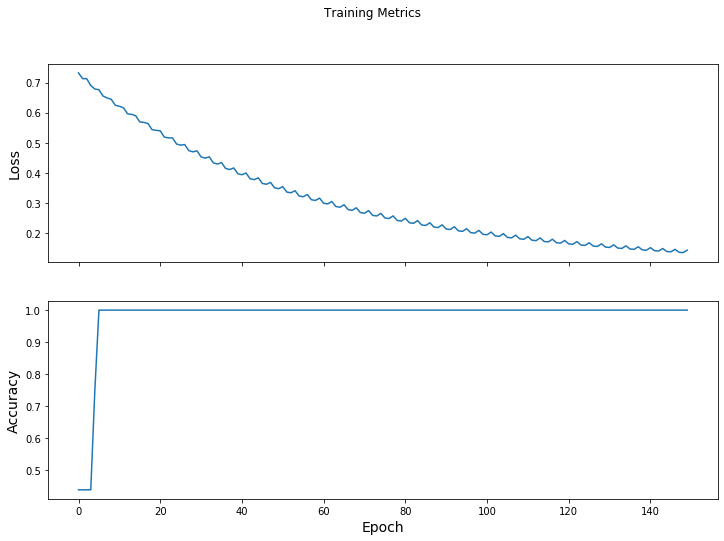

In [16]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(records['Loss'])

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(records['Accuracy'])
plt.show()

In [17]:
model.W[0].numpy()[0]

-0.14358452

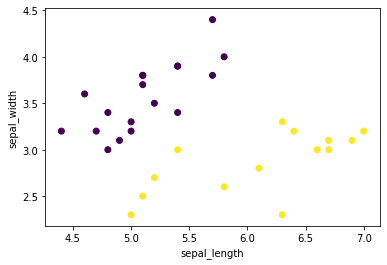

In [38]:
tdataset = tf.data.experimental.CsvDataset(fname, [tf.float32, tf.float32, tf.float32, tf.float32, tf.int32], 
                                         header=True)
# 暂时只保留而分类
def func(*items):
    return items[4] != 2
tdataset = tdataset.filter(func)
tfeatures, tlabels = next(iter(tdataset.batch(32).map(pack_features_vector)))
#plt.scatter(tdataset[0],
#            tdataset[1],
#            c=tlabels,
#            cmap='viridis')
flag = tf.round(tf.sigmoid(model(features)))
flag = tf.reshape(tf.cast(flag, dtype=tf.int32), [-1])
flag
plt.scatter(tsamples[0], tsamples[1], c=flag, cmap="viridis")

plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.show()